In [78]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn.linear_model as skl_lm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [79]:
# Import the dataset
df = pd.read_csv('https://raw.githubusercontent.com/vincenzorrei/EDU-Datasets/refs/heads/main/Default.csv')

# Set the index
df.set_index('Unnamed: 0', inplace=True)

# Rename the index
df.index.name = 'Index'

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object.
# We transform 'No' to 0 and 'Yes' to 1
df['default_enc'] = df.default.factorize()[0] # df['default'].factorize() returns a tuple, we only need the first element
df['student_enc'] = df.student.factorize()[0]
df[['default_enc','default','student_enc','student']].head()
df.head(3)


,default,student,balance,income,default_enc,student_enc
Index,,,,,,
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


In [80]:
# Get some information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      10000 non-null  object 
 1   student      10000 non-null  object 
 2   balance      10000 non-null  float64
 3   income       10000 non-null  float64
 4   default_enc  10000 non-null  int64  
 5   student_enc  10000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 546.9+ KB


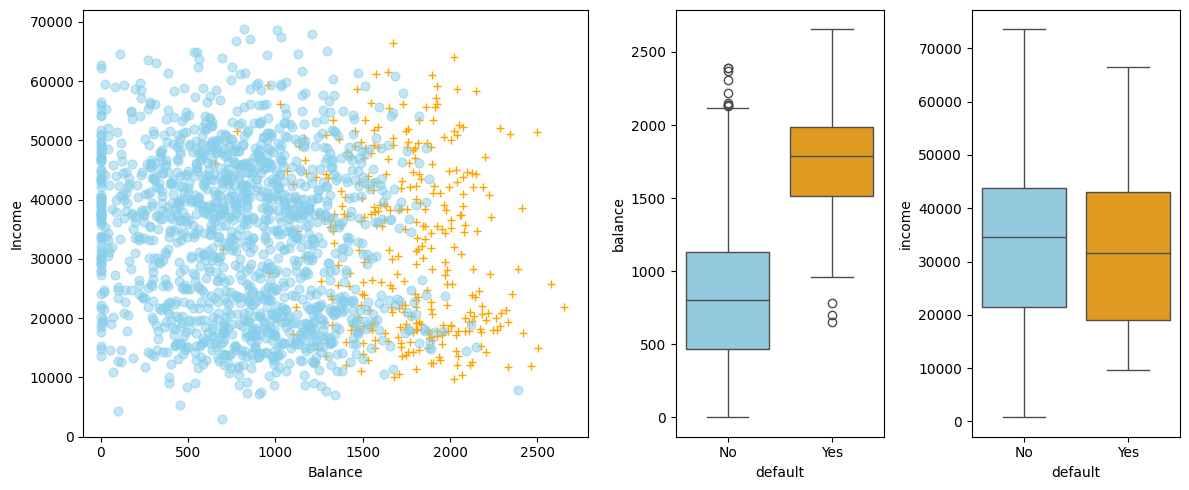

In [81]:
# Plot the data
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default_enc == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default_enc == 1]
df_ = pd.concat([df_no, df_yes])

ax1.scatter(x=df_[df_.default == 'Yes'].balance,
            y=df_[df_.default == 'Yes'].income,
            s=40, c='orange', marker='+',
            linewidths=1)

ax1.scatter(x=df_[df_.default == 'No'].balance,
            y=df_[df_.default == 'No'].income,
            alpha=.5, s=40, c='skyblue', marker='o',)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'skyblue', 'Yes':'orange'}
sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, hue = 'default', palette=c_palette, legend=False)
sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, hue = 'default', palette=c_palette, legend=False)
gs.tight_layout(plt.gcf())


## Train and test split
We now work with balance as X and default as y

In [82]:
# Give the right shape to the data
x = df['balance'].values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df['default_enc']


In [83]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [84]:
# Confirm the shape of the data
print(f'Training set X: {X_train.shape}\nTraining set y: {X_train.shape}\n')
print(f'Test set X: {X_test.shape}\nTest set y: {X_test.shape}')


Training set X: (8000, 1)
Training set y: (8000, 1)

Test set X: (2000, 1)
Test set y: (2000, 1)


## Fit the model

In [85]:
# Fit the model
logistic = skl_lm.LogisticRegression()
logistic.fit(X_train, y_train)


LogisticRegression()

In [86]:
# Predict on train
x_proba = logistic.predict_proba([X_train[0]])
x_pred = logistic.predict([X_train[0]])

print('Class Order:', logistic.classes_)
print('Prob:', x_proba)
print('Model prediction:', x_pred)

Class Order: [0 1]
Prob: [[0.99780427 0.00219573]]
Model prediction: [0]


In [87]:
color_blue = "#1a559e"
color_pink = "#e71d71"

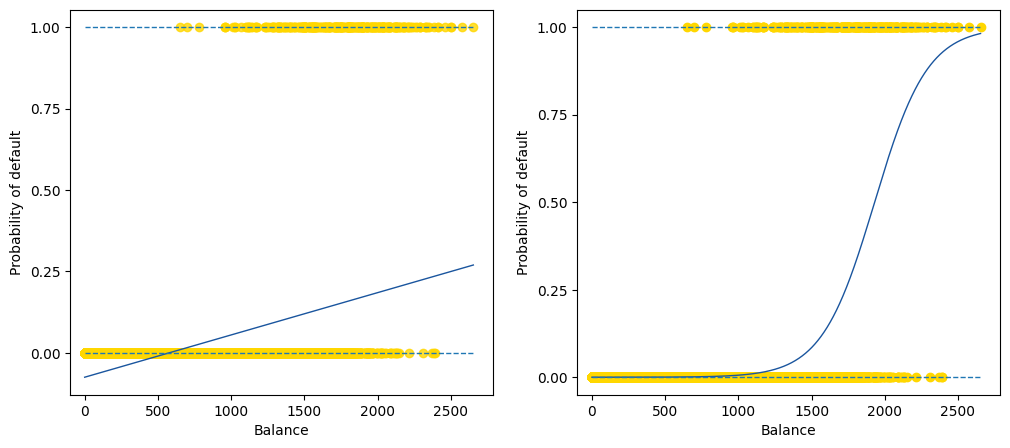

In [88]:
# Compare linear regression and logistic regression
X_space = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)
prob = logistic.predict_proba(X_space)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(x=df.balance, y=df.default_enc, order=1, ci=None,
            scatter_kws={'color':'gold'},
            line_kws={'color':color_blue, 'lw':1}, ax=ax1)
# Right plot
ax2.scatter(x, y, color='gold')
ax2.plot(X_space, prob[:,1], color=color_blue, lw=1)

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

In [89]:
# Example of a new balance value
new_balance_obs = 2000

# Calculate the probability of default
prob_new_obs = logistic.predict_proba([[new_balance_obs]])[0,1]

# Calculate the predicted class (0 or 1)
predicted_class = logistic.predict([[new_balance_obs]])[0]

print(f"Balance = {new_balance_obs}")
print(f"Probability of default: {prob_new_obs*100:.2f}%")
print(f"Predicted class: {predicted_class}")


Balance = 2000
Probability of default: 59.52%
Predicted class: 1


C:\Users\vinor\AppData\Local\Temp\ipykernel_54288\4168626904.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "gx" (-> color='g'). The keyword argument will take precedence.
  plt.plot(new_balance_obs, prob_new_obs, 'gx', label='New observation prediction', color=color_pink)
C:\Users\vinor\AppData\Local\Temp\ipykernel_54288\4168626904.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(new_balance_obs, 0, 'go', label='New observation', color=color_pink)


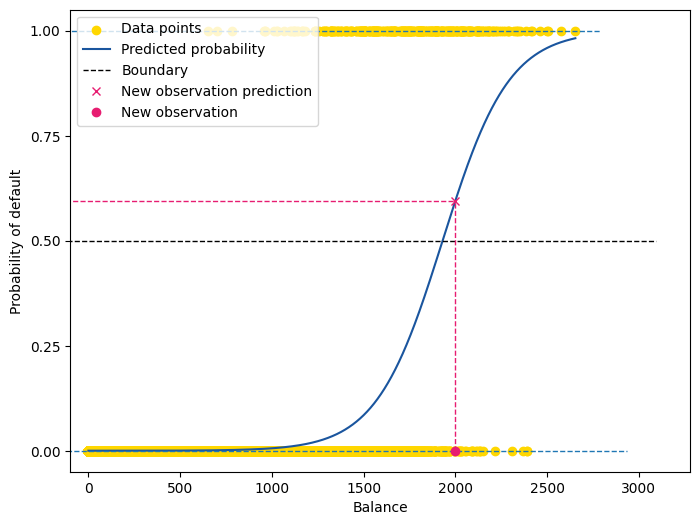

In [90]:
# Plot the graph
plt.figure(figsize=(8, 6))

# Scatter plot and line plot
plt.scatter(x, y, color='gold', label='Data points')
plt.plot(X_space, prob[:, 1], color=color_blue, label='Predicted probability')

# Add horizontal lines upper bound
plt.hlines(1, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1)
# Add horizontal lines lower bound
plt.hlines(0, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1)
# Add horizontal lines, the discriminant boundary
plt.hlines(0.5, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1, colors='black', label='Boundary')
# Add new observation
plt.vlines(new_balance_obs, ymin=0, ymax=prob_new_obs, linestyles='dashed', lw=1, colors=color_pink)
plt.hlines(prob_new_obs, xmin=plt.gca().get_xlim()[0], xmax=new_balance_obs, linestyles='dashed', lw=1, colors=color_pink)
plt.plot(new_balance_obs, prob_new_obs, 'gx', label='New observation prediction', color=color_pink)
plt.plot(new_balance_obs, 0, 'go', label='New observation', color=color_pink)


# Set labels and ticks
plt.ylabel('Probability of default')
plt.xlabel('Balance')
plt.yticks([0, 0.25, 0.5, 0.75, 1.])
plt.xlim(xmin=-100)

# Add legend
plt.legend(loc='upper left')

# Show plot
plt.show()

In [91]:
# Look at the parameters
print('classes: ',logistic.classes_)
print('coefficients: ',logistic.coef_)
print('intercept :', logistic.intercept_)

classes:  [0 1]
coefficients:  [[0.00553357]]
intercept : [-10.68173157]


In [92]:
# statsmodels needs the intercept to be included in the X_train
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train, columns=['balance']))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2()# .tables[1]

Optimization terminated successfully.
         Current function value: 0.079083
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.458      
Date:               2025-03-05 17:37 AIC:              1269.3267  
No. Observations:   8000             BIC:              1283.3011  
Df Model:           1                Log-Likelihood:   -632.66    
Df Residuals:       7998             LL-Null:          -1166.9    
Converged:          1.0000           LLR p-value:      2.3216e-234
No. Iterations:     10.0000          Scale:            1.0000     
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
const       -10.6817    0.4052  -26.3632  0.0000  -11.4759  -9.8876
balance       0.0055    0.0002   22.3104  0.0000    0.0050   0.0060
==================================================================

"""

# Multiple Logistic Regression

In [93]:
X = df[['balance', 'income', 'student_enc']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [94]:
X_train_w_intercept = sm.add_constant(X_train)
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary().tables[1]


Optimization terminated successfully.
         Current function value: 0.078244
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6275,0.539,-19.723,0.000,-11.684,-9.571
balance,0.0057,0.000,22.124,0.000,0.005,0.006
income,-2.856e-06,9.15e-06,-0.312,0.755,-2.08e-05,1.51e-05
student_enc,-0.6480,0.263,-2.468,0.014,-1.163,-0.133


# Confusion Matrix

In [95]:
# Add an intercept to the test dataset
X_test_w_intercept = sm.add_constant(X_test)

# Predict probabilities using the trained model
pred = est.predict(X_test_w_intercept).round(2)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (pred > 0.5).astype(int)


In [96]:
# Print only the first 20 pairs with formatted alignment
print(f"{'Pred Prob':<12} {'Pred Class':<12}")  # Header
print("-" * 25)

for i in range(270, 290):
    print(f"{pred.values[i]:<12} {y_pred.values[i]:<12}")
    

Pred Prob    Pred Class  
-------------------------
0.02         0           
0.02         0           
0.15         0           
0.0          0           
0.01         0           
0.01         0           
0.0          0           
0.0          0           
0.0          0           
0.26         0           
0.0          0           
0.81         1           
0.0          0           
0.01         0           
0.02         0           
0.0          0           
0.0          0           
0.0          0           
0.35         0           
0.0          0           


In [97]:
print(y_pred.value_counts())


0    1971
1      29
Name: count, dtype: int64


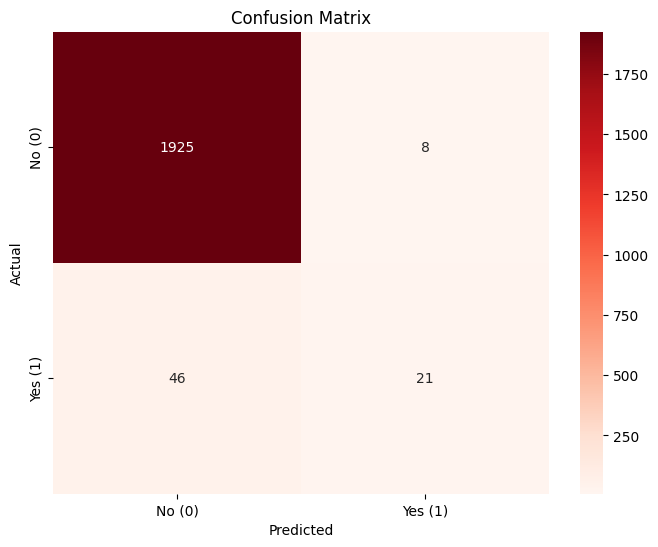

In [98]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Reds',
            xticklabels=['No (0)', 'Yes (1)'],
            yticklabels=['No (0)', 'Yes (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [99]:
# Function to evaluate the performance of a classification model
def evaluate_classification_performance(y_test, y_pred):
    """
    Evaluate and print out standard classification metrics.
    """
    # Compute the confusion matrix
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate specificity = TN / (TN + FP)
    specificity = tn / (tn + fp)
    
    # Calculate other metrics using scikit-learn
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    # FPR = 1 - specificity
    fpr = 1 - specificity
    
    # Print all metrics in a neat format
    print(f"Accuracy:    {accuracy:.2f}")
    print(f"Precision:   {precision:.2f}")
    print(f"Recall:      {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"FPR:         {fpr:.2f}")
    print(f"F1 Score:    {f1:.2f}")
    
    # Optionally return metrics in a dictionary if needed
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'fpr': fpr,
        'f1_score': f1
    }


In [100]:
metrics_dict = evaluate_classification_performance(y_test, y_pred)


Accuracy:    0.97
Precision:   0.72
Recall:      0.31
Specificity: 1.00
FPR:         0.00
F1 Score:    0.44


In [101]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1933
           1       0.72      0.31      0.44        67

    accuracy                           0.97      2000
   macro avg       0.85      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



# Roc Curve

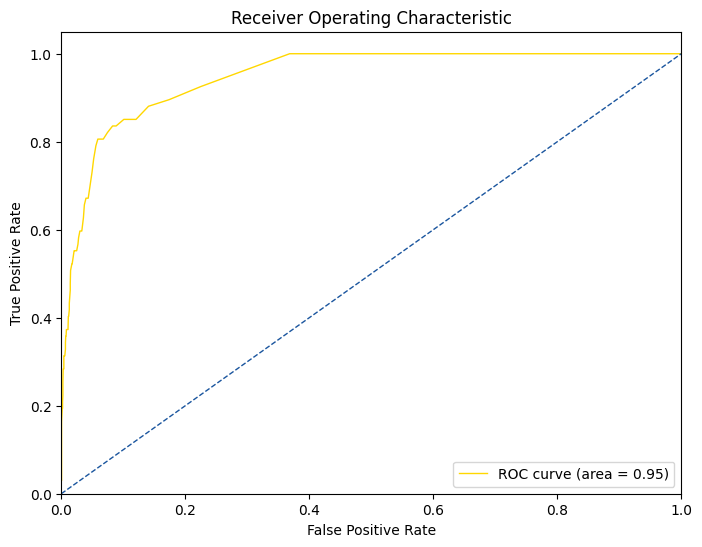

In [102]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Calculate AUC
roc_auc = roc_auc_score(y_test, pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='gold', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color=color_blue, lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [103]:
# Calculate the Gini coefficient
gini = 2 * roc_auc - 1
print('Gini coefficient: %.2f' % gini)

Gini coefficient: 0.90


# Managing Unbalanced Dataset

## Importance of Managing Datasets in Classification

Managing datasets effectively is crucial in classification tasks for several reasons:

1. **Class Imbalance**: In many real-world scenarios, datasets are imbalanced, meaning some classes are underrepresented compared to others. This can lead to biased models that perform well on the majority class but poorly on the minority class. Techniques like oversampling, undersampling, and SMOTE (Synthetic Minority Over-sampling Technique) help address this issue by balancing the class distribution.

2. **Model Performance**: Proper dataset management ensures that the model is trained on representative data, leading to better generalization and performance on unseen data. This includes splitting the data into training and test sets, and sometimes a validation set, to evaluate the model's performance accurately.

3. **Data Quality**: Cleaning and preprocessing the data, such as handling missing values, removing duplicates, and normalizing features, are essential steps to ensure the quality of the dataset. High-quality data leads to more reliable and accurate models.

4. **Bias and Variance Trade-off**: Managing the dataset helps in achieving a balance between bias and variance. Properly splitting the data and using techniques like cross-validation can help in finding the right model complexity that generalizes well to new data.

5. **Feature Engineering**: Creating new features or transforming existing ones can significantly impact the model's performance. Effective dataset management includes feature selection and engineering to enhance the model's predictive power.

In summary, managing datasets is a fundamental aspect of building robust and reliable classification models. It ensures that the model is trained on balanced, high-quality data, leading to better performance and generalization.

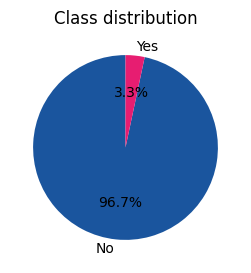

In [104]:
# plot piechart of the classes
plt.figure(figsize=(4, 3))
plt.pie(df['default'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90, colors=[color_blue, color_pink])
plt.title('Class distribution')
plt.show()


In [105]:
df

,default,student,balance,income,default_enc,student_enc
Index,,,,,,
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0
...,...,...,...,...,...,...
9996,No,No,711.555020,52992.378914,0,0
9997,No,No,757.962918,19660.721768,0,0
9998,No,No,845.411989,58636.156984,0,0


## SMOTE

### SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE is a technique used to address class imbalance in datasets. It works by generating synthetic samples for the minority class to balance the class distribution. Here’s a brief explanation:

1. **Identify Minority Class**: SMOTE identifies the minority class in the dataset.
2. **Generate Synthetic Samples**: For each sample in the minority class, SMOTE selects one or more of its nearest neighbors and generates new synthetic samples along the line segments joining the sample and its neighbors.
3. **Balance the Dataset**: The synthetic samples are added to the dataset, increasing the representation of the minority class and balancing the class distribution.

SMOTE helps improve the performance of machine learning models by providing a more balanced dataset, which reduces the bias towards the majority class.

In [106]:
from imblearn.over_sampling import SMOTE


In [ ]:
# Choose the variables to use
data = df[['balance', 'income', 'student_enc', 'default_enc']]


In [108]:
# 1. Split into train and test sets, stratifying by y
train, test = train_test_split(data, test_size=0.2, stratify=y, random_state=42)


In [ ]:
print("----- TEST -----")
print(test.value_counts('default_enc'))


Count in TEST set
default_enc
0    1933
1      67
Name: count, dtype: int64


In [ ]:
print("----- TRAIN -----")
print(train.value_counts('default_enc'))


default_enc
0    7734
1     266
Name: count, dtype: int64


In [109]:
train.head()


,balance,income,student_enc,default_enc
Index,,,,
2721,824.547830,29088.111348,1,0
6169,20.964504,62862.751827,0,0
7724,773.593731,29661.463532,0,0
8129,908.174290,46791.036356,0,0
3566,1049.603574,11137.861039,1,0


In [110]:
# 2. Exclude observations in the test set from the original dataset
data_no_test = data.drop(train.index)


In [111]:
# 3. Compute the maximum possible oversampling ratio (MAX)
n_majority = (data_no_test['default_enc'] == 0).sum()
n_minority = (data_no_test['default_enc'] == 1).sum()
max_ratio = n_majority / n_minority  # Maximum possible ratio

print(f"X_majority (NO): {n_majority}")
print(f"X_minority (YES): {n_minority}")
print(f"Maximum oversampling ratio (on original majority): {max_ratio:.2f}")


X_majority (NO): 1933
X_minority (YES): 67
Maximum oversampling ratio (on original majority): 28.85


In [112]:
# 4. Select a ratio lower than MAX
selected_ratio = 3.0  
selected_ratio = min(selected_ratio, max_ratio)  # Example: choose 3.0 or less if max_ratio < 3.0

print(f"Selected oversampling ratio: {selected_ratio:.2f}")

Selected oversampling ratio: 3.00


In [113]:
# 5. Compute the number of majority class observations to sample
n_majority_sample = int(n_minority * selected_ratio)

print(f"Number of majority class observations to sample: {n_majority_sample}")

Number of majority class observations to sample: 201


In [114]:
# 6. Sample the majority class
majority_sampled_df = data_no_test[data_no_test['default_enc'] == 0].sample(n=n_majority_sample, random_state=42)


In [115]:
# 7. Extract the minority class and merge with sampled majority class observations
minority_df = data_no_test[data_no_test['default_enc'] == 1]


In [116]:
# 8. Concatenate the sampled majority class (reduced) and the minority class (full)
unbalanced_df = pd.concat([majority_sampled_df, minority_df])


In [130]:
# NOTE: the dataset is still unbalanced
print(unbalanced_df.value_counts('default_enc'))


default_enc
0    201
1     67
Name: count, dtype: int64


At this point, the dataset is still imbalanced, but we have selected a number of observations from the majority class that respects the ratio we decided to use for oversampling.

This means that we have reduced the number of majority class samples to match the oversampling ratio, but the dataset has not yet been balanced using SMOTE or other techniques.

In [118]:
# 8. Apply SMOTE to balance the minority class to the majority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(unbalanced_df.drop(columns=['default_enc']), unbalanced_df['default_enc'])


NOTE: The train dataset is now perfectly balanced

In [131]:
print(y_train_resampled.value_counts())

default_enc
0    201
1    201
Name: count, dtype: int64


In [ ]:
# Calculate the number of observations excluded from the majority class
excluded_majority = n_majority - n_majority_sample

# Calculate the number of synthetic observations in the train set for minority
n_min_SMOTE = len(y_train_resampled) - len(unbalanced_df)

# Retrieve the number of observations in the test set for the majority class
n_majority_test = len(test[test['default_enc'] == 0])

# Retrieve the number of observations in the test set for the minority class
n_minority_test = len(test[test['default_enc'] == 1])


In [162]:
# Define dataset composition using structured dictionary
composition_data = {

    # Observations sampled for TRAIN from the MAJ_ority
    "MAJ_sampled_train": {"size": n_majority_sample,
                          "label": "MAJ (Train)",
                          "color": "#D9A673"},

    # Observations sampled for TEST from the MAJ_ority
    "MAJ_test": {"size": n_majority_test,
                 "label": "MAJ (Test)",
                 "color": "#C98B5D"},

    # Observations EXCLUDED from TRAIN the MAJ_ority
    "MAJ_excluded_train": {"size": excluded_majority,
                           "label": "MAJ Excluded",
                           "color": "#E8C1A0"},

    # Observations sampled for TRAIN from the min_ority
    "min_train": {"size": n_minority,
                  "label": "min (Train)",
                  "color": "#A3C1DA"},

     # Observations sampled for TEST from the min_ority
    "min_test": {"size": n_minority_test,
                 "label": "min (Test)",
                 "color": "#85A6BF"},

    # Observations generated by SMOTE for TRAIN from the min_ority
    "min_SMOTE_train": {"size": n_min_SMOTE,
                        "label": "min SMOTE (Train)",
                        "color": "#D4EAF7"}
}

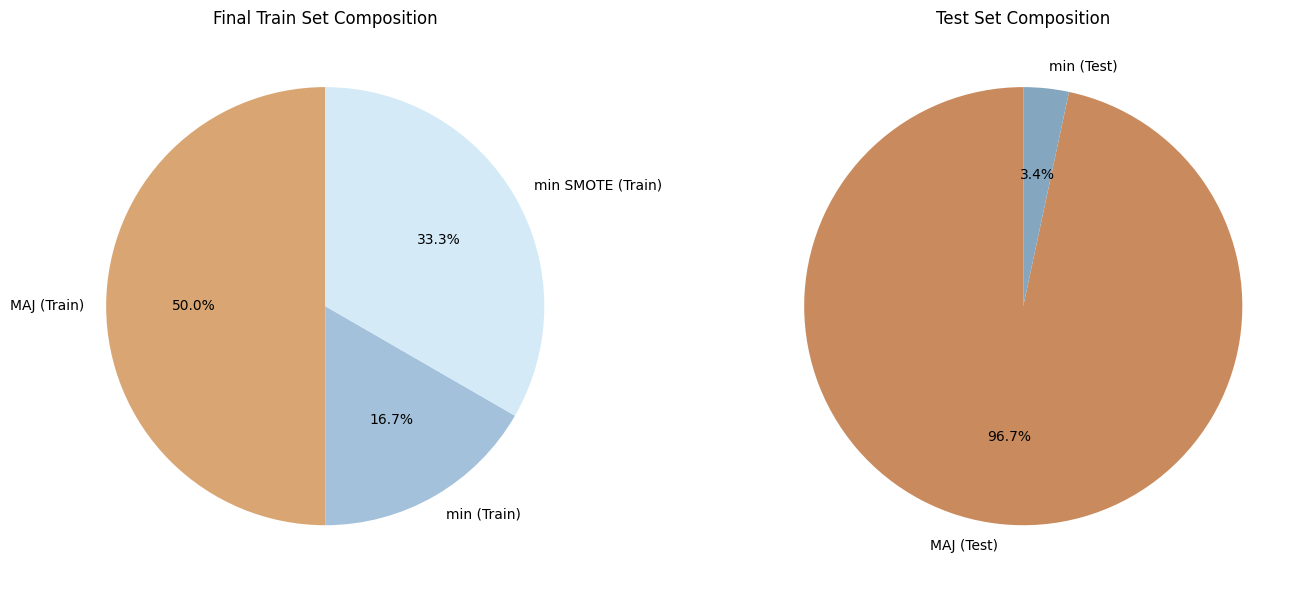

In [163]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie Chart 1: Final Train Set Composition
train_keys = ["MAJ_sampled_train", "min_train", "min_SMOTE_train"]
axes[0].pie(
    [composition_data[k]["size"] for k in train_keys],
    labels=[composition_data[k]["label"] for k in train_keys],
    autopct='%1.1f%%',
    colors=[composition_data[k]["color"] for k in train_keys],
    startangle=90
)
axes[0].set_title("Final Train Set Composition")

# Pie Chart 2: Test Set Composition
test_keys = ["MAJ_test", "min_test"]
axes[1].pie(
    [composition_data[k]["size"] for k in test_keys],
    labels=[composition_data[k]["label"] for k in test_keys],
    autopct='%1.1f%%',
    colors=[composition_data[k]["color"] for k in test_keys],
    startangle=90
)
axes[1].set_title("Test Set Composition")

plt.tight_layout()
plt.show()

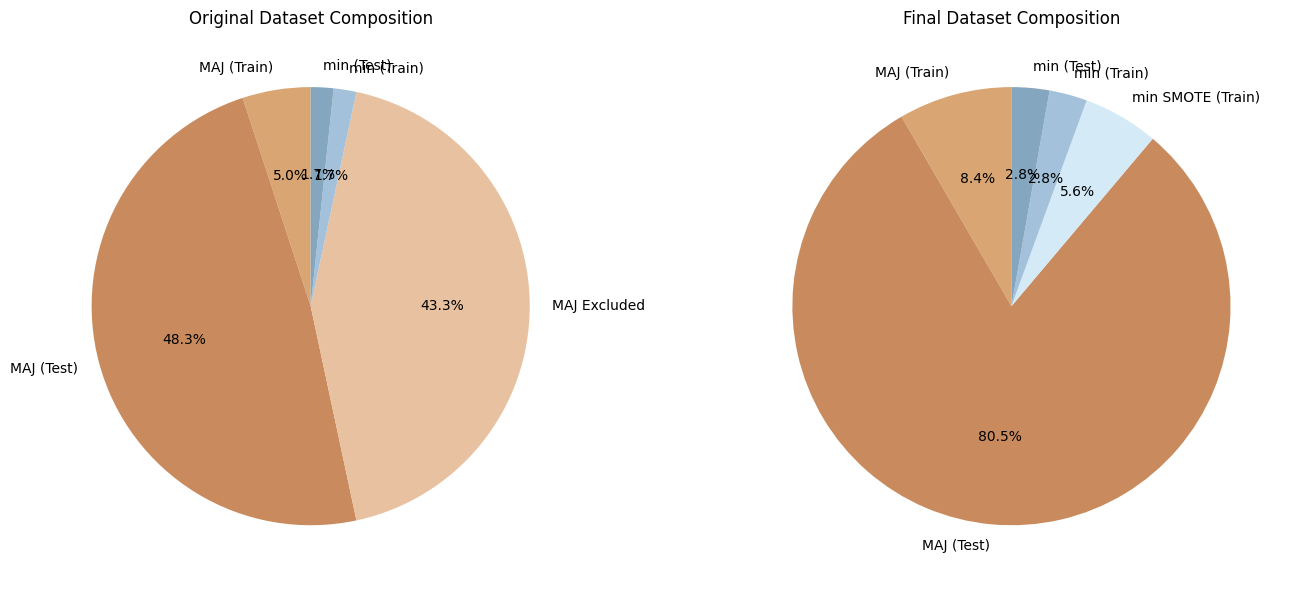

In [164]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie Chart 1: Original Dataset Composition
train_keys = ["MAJ_sampled_train", "MAJ_test","MAJ_excluded_train", "min_train", "min_test"]
axes[0].pie(
    [composition_data[k]["size"] for k in train_keys],
    labels=[composition_data[k]["label"] for k in train_keys],
    autopct='%1.1f%%',
    colors=[composition_data[k]["color"] for k in train_keys],
    startangle=90
)
axes[0].set_title("Original Dataset Composition")

# Pie Chart 2: Test Set Composition
test_keys = ["MAJ_sampled_train", "MAJ_test", "min_SMOTE_train", "min_train", "min_test"]
axes[1].pie(
    [composition_data[k]["size"] for k in test_keys],
    labels=[composition_data[k]["label"] for k in test_keys],
    autopct='%1.1f%%',
    colors=[composition_data[k]["color"] for k in test_keys],
    startangle=90
)
axes[1].set_title("Final Dataset Composition")

plt.tight_layout()
plt.show()